<a href="https://colab.research.google.com/github/amitkumar200890/AllSourceCode/blob/main/%5BCS6375_Project%5D_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Recurrent Neural Networks (RNN) for timeseries prediction

**Team Members**  
**Amit Kumar** [axk210047]  
**Bharath Tej Chinimilli** [bxc200031]  
**Raj Mishra** [rxm190093]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
class TimePredictor:
    def __init__(self, num_hidden, num_iter, alpha, strURL, datasetRatio):
        self.num_hidden = num_hidden
        self.num_iter = num_iter
        self.alpha = alpha
        self.strURL = strURL
        self.lambda1 = 0.90
        self.lambda2 = 0.99
        self.datasetRatio = datasetRatio
        self.dataSetSize = 0
        self.train_mse = 0
        self.test_mse = 0

        self.loss_train = 0.9
        self.loss_test = 0.9

        self.sequence_length = 12

        xavier_init = (1.0/np.sqrt(num_hidden + 1))
        
        # Initialisation of weights and bais
        self.weightF = np.random.randn(num_hidden, num_hidden + 1) * xavier_init
        self.biasf = np.ones((num_hidden,1))
        self.weightI = np.random.randn(num_hidden, num_hidden + 1) * xavier_init
        self.biasi = np.zeros((num_hidden,1))
        self.weightC = np.random.randn(num_hidden, num_hidden + 1) * xavier_init
        self.biasc = np.zeros((num_hidden, 1))
        self.weightO = np.random.randn(num_hidden, num_hidden + 1) * xavier_init
        self.biaso = np.zeros((num_hidden,1))
        self.weightV = np.random.randn(1, num_hidden) * xavier_init   
        self.biasv = np.zeros((1,1))

        self.weightFD = np.zeros_like(self.weightF)
        self.weightID = np.zeros_like(self.weightI)
        self.weightCD = np.zeros_like(self.weightC)
        self.weightOD = np.zeros_like(self.weightO)
        self.weightVD = np.zeros_like(self.weightV)

        self.biasfD = np.zeros_like(self.biasf)
        self.biasiD = np.zeros_like(self.biasi)
        self.biascD = np.zeros_like(self.biasc)
        self.biasoD = np.zeros_like(self.biaso)
        self.biasvD = np.zeros_like(self.biasv)

        self.mWF = np.zeros_like(self.weightF)
        self.mbf = np.zeros_like(self.biasf)
        self.mWI = np.zeros_like(self.weightI)
        self.mbi = np.zeros_like(self.biasi)
        self.mWC = np.zeros_like(self.weightC)
        self.mbc = np.zeros_like(self.biasc)
        self.mWO = np.zeros_like(self.weightO)
        self.mbo = np.zeros_like(self.biaso)
        self.mWV = np.zeros_like(self.weightV)
        self.mbv = np.zeros_like(self.biasv)

        self.vWF = np.zeros_like(self.weightF)
        self.vbf = np.zeros_like(self.biasf)
        self.vWI = np.zeros_like(self.weightI)
        self.vbi = np.zeros_like(self.biasi)
        self.vWC = np.zeros_like(self.weightC)
        self.vbc = np.zeros_like(self.biasc)
        self.vWO = np.zeros_like(self.weightO)
        self.vbo = np.zeros_like(self.biaso)
        self.vWV = np.zeros_like(self.weightV)
        self.vbv = np.zeros_like(self.biasv)

        self.train_pred = []
        self.test_pred = []
        self.mse_array = []
        self.train_true = []
        self.test_true = []

    # Utility function to claulate sigmoid and derivative of sigmoid
    def sigmoid_utility(self, x, flag_der =False):
        x_safe = x + 1e-12
        s = 1 / (1+np.exp(-x_safe))  
        if flag_der: 
            return s * (1 - s)
        else: 
            return s

    # Utility function to claulate tanh and derivative of tanh
    def tanh_utility(self, x, flag_der = False):
        x_safe = x + 1e-12
        t = (np.exp(x_safe) - np.exp(-x_safe)) / (np.exp(x_safe) + np.exp(-x_safe))
        if flag_der:
            return 1 - t**2
        else:
            return t

    # Function to clear all the weights and bais
    def clear_gradients(self):
        self.weightFD.fill(0)
        self.weightID.fill(0)
        self.weightCD.fill(0)
        self.weightOD.fill(0)
        self.weightVD.fill(0)

        self.biasfD.fill(0)
        self.biasiD.fill(0)
        self.biascD.fill(0)
        self.biasoD.fill(0)
        self.biasvD.fill(0)

    # Function to update all the weights and bais based on Back-propogation value set
    def update_parameters(self):
        #calculate the m parameters from m and current flag_ders
        self.mWF = (self.lambda1*self.mWF + (1-self.lambda1)*self.weightFD)
        self.mWI = (self.lambda1*self.mWI + (1-self.lambda1)*self.weightID)
        self.mWC = (self.lambda1*self.mWC + (1-self.lambda1)*self.weightCD)
        self.mWO = (self.lambda1*self.mWO + (1-self.lambda1)*self.weightOD)
        self.mWV = (self.lambda1*self.mWV + (1-self.lambda1)*self.weightVD)

        self.mbf = (self.lambda1*self.mbf + (1-self.lambda1)*self.biasfD)
        self.mbi = (self.lambda1*self.mbi + (1-self.lambda1)*self.biasiD)
        self.mbc = (self.lambda1*self.mbc + (1-self.lambda1)*self.biascD)
        self.mbo = (self.lambda1*self.mbo + (1-self.lambda1)*self.biasoD)
        self.mbv = (self.lambda1*self.mbv + (1-self.lambda1)*self.biasvD)

        #calculate the v parameters from v and current flag_ders
        self.vWF = (self.lambda2*self.vWF + (1-self.lambda2)*(self.weightFD**2))
        self.vWI = (self.lambda2*self.vWI + (1-self.lambda2)*(self.weightID**2))
        self.vWC = (self.lambda2*self.vWC + (1-self.lambda2)*(self.weightCD**2))
        self.vWO = (self.lambda2*self.vWO + (1-self.lambda2)*(self.weightOD**2))
        self.vWV = (self.lambda2*self.vWV + (1-self.lambda2)*(self.weightVD**2))

        self.vbf = (self.lambda2*self.vbf + (1-self.lambda2)*(self.biasfD**2))
        self.vbi = (self.lambda2*self.vbi + (1-self.lambda2)*(self.biasiD**2))
        self.vbc = (self.lambda2*self.vbc + (1-self.lambda2)*(self.biascD**2))
        self.vbo = (self.lambda2*self.vbo + (1-self.lambda2)*(self.biasoD**2))
        self.vbv = (self.lambda2*self.vbv + (1-self.lambda2)*(self.biasvD**2))

        #update the parameters
        self.weightF = self.weightF - self.alpha*((self.mWF)/(np.sqrt(self.vWF) + 1e-6))
        self.weightI = self.weightI - self.alpha*((self.mWI)/(np.sqrt(self.vWI) + 1e-6))
        self.weightC = self.weightC - self.alpha*((self.mWC)/(np.sqrt(self.vWC) + 1e-6))
        self.weightO = self.weightO - self.alpha*((self.mWO)/(np.sqrt(self.vWO) + 1e-6))
        self.weightV = self.weightV - self.alpha*((self.mWV)/(np.sqrt(self.vWV) + 1e-6))

        self.biasf = self.biasf - self.alpha*((self.mbf)/(np.sqrt(self.vbf) + 1e-6))
        self.biasi = self.biasi - self.alpha*((self.mbi)/(np.sqrt(self.vbi) + 1e-6))
        self.biasc = self.biasc - self.alpha*((self.mbc)/(np.sqrt(self.vbc) + 1e-6))
        self.biaso = self.biaso - self.alpha*((self.mbo)/(np.sqrt(self.vbo) + 1e-6))
        self.biasv = self.biasv - self.alpha*((self.mbv)/(np.sqrt(self.vbv) + 1e-6))

    # Function to pre-process data and create train and test data array
    def pre_process_raw_data(self):
        dataFrame = pd.read_csv('https://drive.google.com/uc?export=download&id=' +self.strURL.split('/')[-2], encoding = 'unicode_escape', delimiter = ',')
        
        # To drop any blank rows
        dataFrame.dropna(axis = 0, how = 'any', thresh = None, inplace = True) 

        # Drop duplicate rows
        dataFrame.drop_duplicates(inplace=True)

        X = dataFrame[['T (degC)', 'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)']]
        
        features = X['T (degC)']
        target = X['T (degC)']
        
        newLenDataset = int(len(X)*self.datasetRatio)
        self.dataSetSize = newLenDataset

        trimmedFeature = features[0:newLenDataset]
        trimmedTarget = target[0:newLenDataset]

        X_train, X_test, Y_train, Y_test = train_test_split(trimmedFeature, trimmedTarget, train_size=0.8, random_state=123, shuffle=False)

        print("Len of X_train: " + str(len(X_train)))
        print("Len of X_test: " + str(len(X_test)))

        X_train = X_train.to_numpy().reshape(-1,1)
        X_test = X_test.to_numpy().reshape(-1,1)
        
        X_train_scaler = MinMaxScaler()
        X_test_scaler = MinMaxScaler()

        X_train = X_train_scaler.fit_transform(X_train)
        X_test = X_test_scaler.fit_transform(X_test)

        return X_train, X_test


    def forward_propagation(self, prev_h, x, prev_c):
        z_t = np.row_stack((prev_h, x[0]))

        gate_i = self.sigmoid_utility(np.dot(self.weightI, z_t) + self.biasi)
        gate_f = self.sigmoid_utility(np.dot(self.weightF, z_t) + self.biasf)
        hat_c = self.tanh_utility(np.dot(self.weightC, z_t) + self.biasc)

        gate_output = self.sigmoid_utility(np.dot(self.weightO, z_t) + self.biaso)
        c = gate_f*prev_c + gate_i*hat_c
        hNext = gate_output*self.tanh_utility(c)

        v = np.dot(self.weightV,hNext) + self.biasv
        return v, hNext, c, gate_output, hat_c, gate_f, gate_i, z_t
        
    def back_propagation(self, y, v, dhNext, dcNext, prev_c, z_t, f, i, hat_c, c, o, h):
        VD = np.copy(v)
        VD[np.argmax(y)] -= 1

        der_h = np.dot(self.weightV.transpose(), VD)
        der_h  += dhNext

        self.weightVD += np.dot(VD, h.transpose())
        self.biasvD += VD

        der_c  = der_h  * o * self.tanh_utility(self.tanh_utility(c), flag_der=True)
        der_c  += dcNext
        dhat_c = der_c  * i
        der_ac = dhat_c * self.tanh_utility(dhat_c, flag_der=True)
        self.weightCD += np.dot(der_ac, z_t.transpose())
        self.biascD += der_ac

        der_o = der_h * self.tanh_utility(c)
        der_ao = der_o * self.sigmoid_utility(c, flag_der=True)
        self.weightOD += np.dot(der_ao, z_t.transpose())
        self.biasoD += der_ao

        der_f = der_c  * prev_c
        der_af = der_f * self.sigmoid_utility(f, flag_der=True)
        self.weightFD += np.dot(der_af, z_t.transpose())
        self.biasfD += der_af
        
        der_i = der_c  * hat_c
        der_ai = der_i * self.sigmoid_utility(i, flag_der=True)
        self.weightID += np.dot(der_ai, z_t.transpose())
        self.biasiD += der_ai
        
        dz_t = (np.dot(self.weightF.transpose(), der_af)
            + np.dot(self.weightI.transpose(), der_ai)
            + np.dot(self.weightC.transpose(), der_ac)
            + np.dot(self.weightO.transpose(), der_ao))
        
        prev_dh = dz_t[:self.num_hidden, :]
        prev_dc = f * der_c
        return prev_dh, prev_dc
    
    def single_sequence_processing(self, x_data, y_data, prev_h, prev_c):
        x = {}
        z_t = {}
        f_gate = {}
        i_gate = {}
        hat_c = {}
        c = {}
        o_gate = {}
        v = {}
        h = {}

        h[-1] = np.copy(prev_h)
        c[-1] = np.copy(prev_c)
        mse = 0

        for i in range(self.sequence_length):
            v[i], h[i], c[i], o_gate[i], hat_c[i], f_gate[i], i_gate[i], z_t[i] = self.forward_propagation( h[i-1], x_data[i], c[i-1])
        
        mse = mean_squared_error(y_data[self.sequence_length-1],v[self.sequence_length-1])
        self.mse_array.append(mse)
        self.train_pred.append(v[self.sequence_length-1])
        self.train_true.append(y_data[self.sequence_length-1])

        # Clear all weight and bias after each iteration of batch data
        self.clear_gradients()

        dhNext = np.zeros_like(prev_h[0])
        dcNext = np.zeros_like(prev_c[0])

        for i in reversed(range(self.sequence_length)):
            dhNext, dcNext = self.back_propagation(y_data[i], v[i], dhNext, dcNext, c[i-1], z_t[i], f_gate[i], i_gate[i], hat_c[i], c[i], o_gate[i], h[i])
        
        return mse, h[self.sequence_length-1], c[self.sequence_length-1]

    def single_sequence_testing(self, x_data, y_data, prev_h, prev_c):
        x = {}
        z_t = {}
        f_gate = {}
        i_gate = {}
        hat_c = {}
        c = {}
        o_gate = {}
        v = {}
        h = {}

        h[-1] = np.copy(prev_h)
        c[-1] = np.copy(prev_c)
        loss = 0
        train_true = []
        y_pred = []
        for i in range(self.sequence_length):
            v[i], h[i], c[i], o_gate[i], hat_c[i], f_gate[i], i_gate[i], z_t[i] = self.forward_propagation(h[i-1], x_data[i], c[i-1])

        loss = mean_squared_error(y_data[self.sequence_length-1],v[self.sequence_length-1])

        self.test_pred.append(v[self.sequence_length-1])
        self.test_true.append(y_data[self.sequence_length-1])

        return loss, h[self.sequence_length-1], c[self.sequence_length-1]

    def train_model(self, X_train):
        
        loss_array = []
        accuracy_array = []

        final_h = np.zeros((self.num_hidden, 1))
        final_c = np.zeros((self.num_hidden, 1))
        
        const_temp1 = 0.999
        const_temp2 = 0.001

        for iter in range(self.num_iter):
            prev_h = np.zeros((self.num_hidden, 1))
            prev_c = np.zeros((self.num_hidden, 1))
            for i in range(0, len(X_train) - self.sequence_length, self.sequence_length):
                x_batch = X_train[i: i + self.sequence_length]
                y_batch = X_train[i + 1: i + self.sequence_length + 1]

                mse_inter, prev_h, prev_c = self.single_sequence_processing(x_batch, y_batch, prev_h, prev_c)

                final_h = prev_h
                final_c = prev_c

                self.loss_train = (self.loss_train * const_temp1) + (mse_inter * const_temp2)
                loss_array.append(self.loss_train)

                # Update weight and bias based on backprop output
                self.update_parameters()

        y_pred = []
        for i in range(0,len(self.train_pred)):
            y_pred.append(self.train_pred[i][0][0])
        mse = mean_squared_error(y_pred,self.train_true)

        self.train_mse = mse

        return loss_array, final_h, final_c

    def test_model(self, X_test, prev_h, prev_c):

        mse_array = []

        const_temp1 = 0.999
        const_temp2 = 0.001

        for i in range(0, len(X_test) - self.sequence_length, self.sequence_length):
          x_batch = X_test[i: i + self.sequence_length]
          y_batch = X_test[i + 1: i + self.sequence_length + 1]

          mse_inter, prev_h, prev_c = self.single_sequence_testing(x_batch, y_batch, prev_h, prev_c)
          self.loss_test = (self.loss_test * const_temp1) + (mse_inter * const_temp2)
          mse_array.append(self.loss_test)
        
        y_pred = []
        for i in range(0,len(self.test_pred)):
            y_pred.append(self.test_pred[i][0][0])

        mse = mean_squared_error(y_pred,self.test_true)

        self.test_mse = mse

        self.print_result()

        return mse_array

    def print_result(self):
        print("Learning Rate: " + str(self.alpha))
        print("Iteration: " + str(self.num_iter))
        print("Dataset Size: " + str(self.dataSetSize))
        print("Regularization Paramter 1: ",str(self.lambda1))
        print("Regularization Paramter 2: ",str(self.lambda2))
        print("MSE after training: " + str(self.train_mse))
        print("MSE after Testing: " + str(self.test_mse))


In [ ]:
strURL = 'https://drive.google.com/file/d/1Jc6jLK9Xq67jYSVJXwVxTQ4s5Tqp5FvU/view?usp=sharing'
obj = TimePredictor(num_hidden = 20, num_iter = 1, alpha = 0.1, strURL = strURL, datasetRatio = 1)

Len of X_train: 336099
Len of X_test: 84025


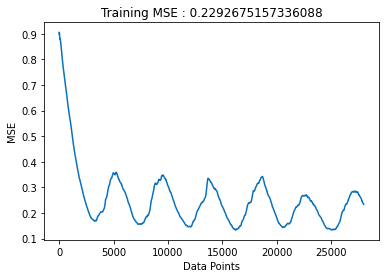

In [ ]:
train,test = obj.pre_process_raw_data()
loss_array,prev_h,prev_c = obj.train_model(train)
plt.plot([i for i in range(len(loss_array))], loss_array,color="#0A71BD")
plt.xlabel("Data Points")
plt.ylabel("MSE")
plt.title("Training MSE : " + str(obj.train_mse))
plt.savefig("train_MSE.png")

Learning Rate: 0.1
Iteration: 1
Dataset Size: 420124
Regularization Paramter 1:  0.9
Regularization Paramter 2:  0.99
MSE after training: 0.2292675157336088
MSE after Testing: 0.2841183264976604


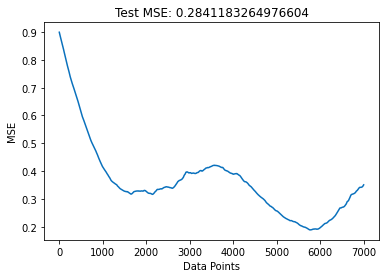

In [ ]:
loss_array = obj.test_model(test,prev_h,prev_c)
plt.plot([i for i in range(len(loss_array))], loss_array,color="#0A71BD")
plt.xlabel("Data Points")
plt.ylabel("MSE")
plt.title("Test MSE: " + str(obj.test_mse))
plt.savefig("test_MSE.png")